In [9]:
from itertools import starmap, chain
from collections import Counter
import operator as op

import numpy as np
import pandas as pd
from ggplot import *
from keras import models
from keras import layers
from keras import callbacks
from fn import F

from chempred import chemdner
from chempred import preprocessing as pp
from chempred import model
from chempred import training

### Read and preprocess data

In [10]:
MODELS = "models"
ABSTRACTS = "abstracts"
ANNOTATIONS = "annotations"
DETECTOR = "detector"
TAGGER = "tagger"

NCHAR = pp.MAXCHAR + 1
EMBED = 50

In [11]:
detector = "configs/detector-config.json"
config = training.read_config(detector)
if set(config.mapping.values()) != {0, 1}:
    raise ValueError("The detector's mapping must be binary")
ncls = 2

# read training data
train_abstracts = chemdner.read_abstracts(config.train_data[ABSTRACTS])
train_anno = chemdner.read_annotations(config.train_data[ANNOTATIONS])
train_ids, train_samples, train_fail, train_x, train_y, train_mask = (
    training.process_data(train_abstracts, train_anno, config.window,
                          config.maxlen, config.nonpositive,
                          config.mapping, config.positive)
)
# read testing data
test_abstracts = chemdner.read_abstracts(
    config.test_data[ABSTRACTS])
test_anno = chemdner.read_annotations(
    config.test_data[ANNOTATIONS])
test_ids, test_samples, test_fail, test_x, test_y, test_mask = (
    training.process_data(test_abstracts, test_anno, config.window,
                          config.maxlen, config.nonpositive,
                          config.mapping, config.positive)
)

train_y_onehot = pp.maskfalse(pp.one_hot(train_y), train_mask)
test_y_onehot = pp.maskfalse(pp.one_hot(test_y), test_mask)

In [5]:
train_x.shape, test_x.shape

((188304, 400), (162048, 400))

### Examine class imbalance

In [10]:
counts_train = np.vstack([counts if len(counts) == 2 else np.array([counts[0], 0]) 
                          for counts in [np.unique(cls[mask], return_counts=True)[1] 
                                         for cls, mask in zip(train_y, train_mask)]])
counts_train.sum(axis=0)

array([4655638, 2079174])

In [11]:
counts_test = np.vstack([counts if len(counts) == 2 else np.array([counts[0], 0]) 
                         for counts in [np.unique(cls[mask], return_counts=True)[1] 
                                        for cls, mask in zip(test_y, test_mask)]])
counts_test.sum(axis=0)

array([4002880, 1777524])

### Build a detector model

In [4]:
l_in = layers.Input(shape=(config.maxlen,), name="l_in")
l_emb = layers.Embedding(NCHAR, EMBED, mask_zero=True,
                         input_length=config.maxlen)(l_in)
l_rec = model.build_rec(config.nsteps, config.in_drop,
                        config.rec_drop)(l_emb)
l_out = layers.TimeDistributed(
    layers.Dense(ncls, activation='softmax'), name="l_out")(l_rec)
detector_model = models.Model(l_in, l_out)
detector_model.compile(optimizer="Adam", loss="binary_crossentropy",
                       metrics=["accuracy"])

In [ ]:
with training.training(MODELS, DETECTOR) as (destination, weights):
    # save architecture
    detector_json = detector_model.to_json()
    with open(destination, "w") as json_file:
        json_file.write(detector_json)
    checkpoint = callbacks.ModelCheckpoint(weights, monitor="val_acc",
                                           verbose=1, mode="max",
                                           save_best_only=True)
    detector_model.fit(train_x, train_y_onehot, callbacks=[checkpoint],
                       validation_data=(test_x, test_y_onehot), verbose=1,
                       epochs=config.epochs, batch_size=config.batchsize)

### Annotated entity length distribution and per-class char-level sample size

In [18]:
chemdner_anno_train = list(chain.from_iterable(abstr_anno[1] + abstr_anno[2] 
                                               for abstr_anno in train_anno))
chemdner_anno_len_train = [len(anno.text) for anno in chemdner_anno_train]
chemdner_anno_cls_train = [anno.cls for anno in chemdner_anno_train]
chemdner_anno_lengths_train = pd.DataFrame({"len": chemdner_anno_len_train, 
                                            "cls": chemdner_anno_cls_train})
sorted([(cls, grp["len"].sum()) for cls, grp in chemdner_anno_lengths_train.groupby("cls")], 
       key=op.itemgetter(1), reverse=True)

[('SYSTEMATIC', 106048),
 ('TRIVIAL', 88779),
 ('FAMILY', 52103),
 ('FORMULA', 18988),
 ('ABBREVIATION', 17499),
 ('MULTIPLE', 5623),
 ('IDENTIFIER', 4788),
 ('NO CLASS', 349)]

In [20]:
chemdner_anno_test = list(chain.from_iterable(abstr_anno[1] + abstr_anno[2] 
                                              for abstr_anno in test_anno))
chemdner_anno_len_test = [len(anno.text) for anno in chemdner_anno_test]
chemdner_anno_cls_test = [anno.cls for anno in chemdner_anno_test]
chemdner_anno_lengths_test = pd.DataFrame({"len": chemdner_anno_len_test, 
                                      "cls": chemdner_anno_cls_test})
sorted([(cls, grp["len"].sum()) for cls, grp in chemdner_anno_lengths_test.groupby("cls")], 
       key=op.itemgetter(1), reverse=True)

[('SYSTEMATIC', 85867),
 ('TRIVIAL', 78240),
 ('FAMILY', 48383),
 ('ABBREVIATION', 15996),
 ('FORMULA', 14178),
 ('MULTIPLE', 5265),
 ('IDENTIFIER', 3733),
 ('NO CLASS', 343)]

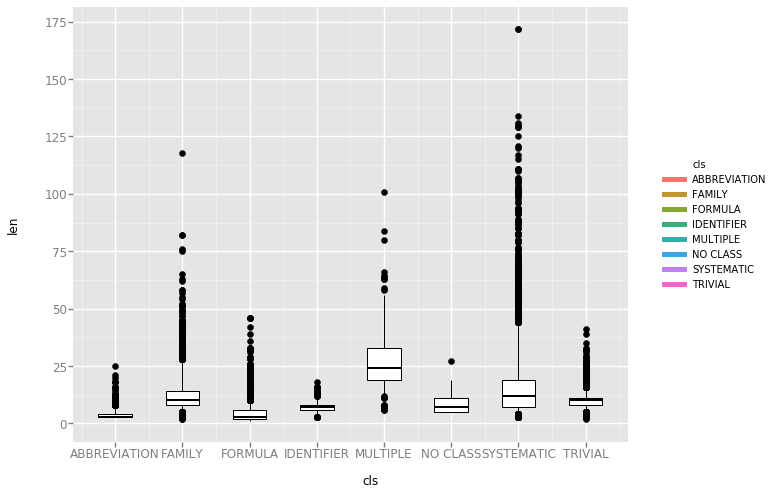

<ggplot: (-9223363274710655228)>

In [9]:
ggplot(chemdner_anno_lengths, aes(fill="cls", x="cls", y="len")) + \
    geom_boxplot()

### Encode data for the tagger model

In [22]:
class_mapping = {cls: i for i, cls in enumerate(set(chemdner_anno_lengths["cls"]))}

encoded_annotations_train = list(map(F(pp.encode_annotation, class_mapping), 
                                     chemdner_anno_train))
encoded_annotations_test = list(map(F(pp.encode_annotation, class_mapping), 
                                    chemdner_anno_test))

tagger_x_train, tagger_y_train = zip(*encoded_annotations_train)
tagger_x_test, tagger_y_test = zip(*encoded_annotations_test)

tagger_y_onehot_train, tagger_y_onehot_test = map(pp.one_hot())

### Build a tagger model

In [ ]:
max_anno_len = max([])

In [ ]:
l_in = layers.Input(shape=(config.maxlen,), name="l_in")
l_emb = layers.Embedding(NCHAR, EMBED, mask_zero=True,
                         input_length=config.maxlen)(l_in)
l_rec = model.build_rec(config.nsteps, config.in_drop,
                        config.rec_drop)(l_emb)
l_out = layers.TimeDistributed(
    layers.Dense(ncls, activation='softmax'), name="l_out")(l_rec)
detector_model = models.Model(l_in, l_out)
detector_model.compile(optimizer="Adam", loss="binary_crossentropy",
                       metrics=["accuracy"])

In [43]:
print(test2_x_encoded[:1].argmin(axis=2))
print(net2.predict(test2_x_encoded[:1]).argmax(axis=2))

[[0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
